# Camera Pose Estimation
This notebook contains ...

[paper by Shotton et al.](https://www.microsoft.com/en-us/research/publication/scene-coordinate-regression-forests-for-camera-relocalization-in-rgb-d-images/) [1]

In [1]:
# We can not provide a full package yet
# and load our python files manually
import sys
sys.path.append('./source/')

***
## 1. Data Loading
In order to get started we first need to download data from the [**7-scenes dataset**](https://www.microsoft.com/en-us/research/project/rgb-d-dataset-7-scenes/). Therefore, just hop into the **/data** folder where you will find a notebook called **load_and_clean_7_scenes_dataset.ipynb**. Just pick a scene of your choice and execute the corresponding cell. 

To get an intuition for the data, we plot a number of `SAMPLES` of random images and corresponding depth maps from the data set `SCENE`. Additionally, the full volumetric image of the scene is displayed.

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


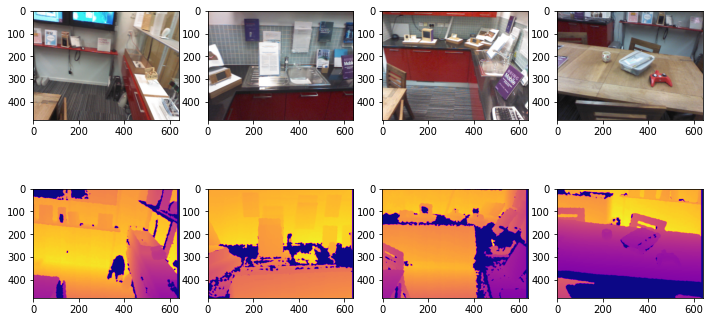

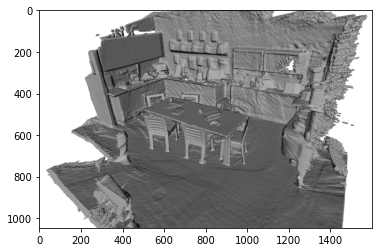

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from source.data_loader import DataLoader 

SCENE = "redkitchen"
DATA_PATH = "./data"
SAMPLES = 4

loader = DataLoader(DATA_PATH)
indices = np.random.choice(loader.get_dataset_length(SCENE), SAMPLES, replace = False)
images, depths, poses = loader.load_dataset(SCENE, indices)

# plot random images 
_, axes = plt.subplots(2, SAMPLES, figsize=(12,6))
for i in range(SAMPLES):
    axes[0,i].imshow(np.swapaxes(images[i], 1, 0))
    axes[1,i].imshow(depths[i].T, cmap=plt.get_cmap("plasma"))
plt.show()

# plot volume
full_scene = np.array(Image.open(f"./data/{SCENE}/{SCENE}.png"))
plt.imshow(full_scene)

***
## 2. Regression Forest

### 2.1 Training
To train a forest for a certain scene we provide the script **/source/train_forest.py**. Initially, all hyperparameters must be set and are displayed in the following table:

| Hyperparameter | Value        | 
| ------------- |:-------------:| 
|TEST_SIZE | *0.5* |
|NUM_TREES | 5 |
|TREE_MAX_DEPTH | 16 |
|NUM_TRAIN_IMAGES_PER_TREE | 500 |
|NUM_SAMPLES_PER_IMAGE | 5000   |
|NUM_PARAMETER_SAMPLES | 1024 |
|FEATURE_TYPE | *DA_RGB / DEPTH* |

We chose all hyperparameters according to the values stated in section 4.4 and Table 1 of [1]. Make sure to  adjust the test size for each dataset since the values vary. Subsequently, the dataset is loaded and split into training and test data. The forest is initialized and the training process started. When the training is finished, the forest object and corresponding parameters are saved. 

Here, we load a trained forest

In [3]:
import os
from source.utils import load_object, millis

OUTPUT = "./output"
PREFIX = "22-03-2022_17-57_redkitchen"

params = load_object(os.path.join(OUTPUT, PREFIX, f"params_{SCENE}.pkl"))
print(f'Loading forest trained on "{SCENE}"')

[print(f'\t{key}: {params[key]}') for key in [
    'TIMESTAMP',
    'TREE_MAX_DEPTH',
    'NUM_TREES',
    'NUM_TRAIN_IMAGES_PER_TREE',
    'NUM_SAMPLES_PER_IMAGE',
    'NUM_PARAMETER_SAMPLES',
    'FEATURE_TYPE']]
    
forest = load_object(os.path.join(OUTPUT, PREFIX, f"trained_forest_{SCENE}.pkl"))

Loading forest trained on "redkitchen"
	TIMESTAMP: 22/03/2022 17:57:56
	TREE_MAX_DEPTH: 16
	NUM_TREES: 5
	NUM_TRAIN_IMAGES_PER_TREE: 500
	NUM_SAMPLES_PER_IMAGE: 5000
	NUM_PARAMETER_SAMPLES: 1024
	FEATURE_TYPE: FeatureType.DA_RGB


### 2.1 Testing
Now, we can use the trained tree and see how it performs on unseen data...

In [4]:
NUM_TEST_IMAGES = 500
NUM_SAMPLES_PER_IMAGE = 800

# Sample points from test data
test_set_indices = params['TEST_INDICES']
test_indices = np.random.choice(test_set_indices, NUM_TEST_IMAGES, replace = False)
images_data = loader.load_dataset(SCENE, test_indices)

# Obtain pixel and world coordinates from sample points
p_s, w_s = loader.sample_from_data_set(
    images_data = images_data,
    num_samples = NUM_SAMPLES_PER_IMAGE)

# Evalulate forest
num_samples = NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE
print(f'Evaluating each tree for {num_samples} samples...')

start = millis()
tree_predictions = forest.evaluate(p_s, images_data)
print(f'Finished after {(millis() - start):5.1F}ms')

images_data = None # free memory

Evaluating each tree for 400000 samples...
Finished after 15722.0ms


### 2.3 Evaluation
Next up, we'll show the results of our training process for the different scenes.

In [5]:
from source.evaluator import get_prediction_error, get_valid_predictions
from source.visualization import draw_pointcloud

In [6]:
valid_predictions = get_valid_predictions(tree_predictions)

total_num_predictions = (NUM_TEST_IMAGES * NUM_SAMPLES_PER_IMAGE * len(tree_predictions))
valid_num_predictions = valid_predictions.shape[0]

print(f'The forest exhibits {(valid_num_predictions / total_num_predictions):.2%} valid predictions')

The forest exhibits 89.88% valid predictions


Tree 0: average deviation = [1.870E+00 +/- 1.167E+00] meters
Tree 1: average deviation = [1.705E+00 +/- 9.257E-01] meters
Tree 2: average deviation = [1.756E+00 +/- 9.691E-01] meters
Tree 3: average deviation = [1.634E+00 +/- 9.413E-01] meters
Tree 4: average deviation = [1.743E+00 +/- 9.798E-01] meters


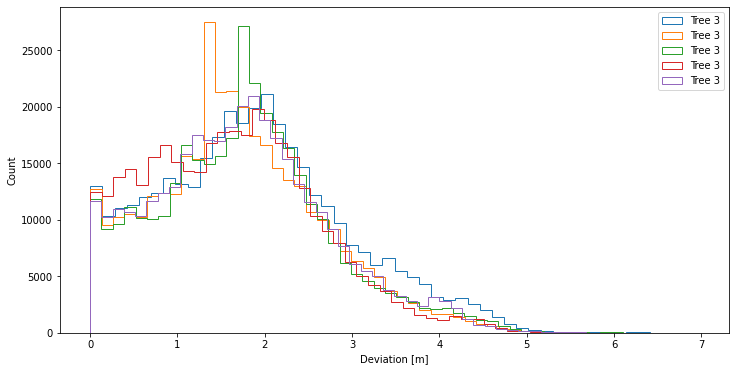

In [7]:
errors = get_prediction_error(tree_predictions, ground_truth=w_s)

plt.figure(figsize=(12,6))

for err in errors:
    plt.hist(err, bins=50, fill=False, histtype='step', label=f'Tree {i}')

plt.xlabel('Deviation [m]')
plt.ylabel('Count')
plt.legend()

for i, err in enumerate(errors):
    print(f'Tree {i}: average deviation = [{np.mean(err):1.3E} +/- {np.var(err):1.3E}] meters')

In [8]:
draw_pointcloud(valid_predictions)

## 3. Predicting Camera Poses

### 3.1 Evaluation